In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets 
import IPython.display as display
from ipywidgets import Layout, Button, Box, Layout, Image, IntSlider, AppLayout

from skimage import data

# Initialize Environments

In [2]:
import os

def createFolder(dir):
  try:
    if not os.path.exists(dir):
      os.makedirs(dir)
  except OSError:
    print(f'ERROR: createFolder{dir}')

createFolder('./data')

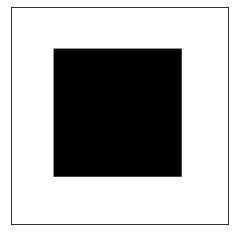

True

In [3]:
def plot(img):
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
img = np.full(shape=(512,512,3),fill_value=255,dtype=np.int32)

left_top = (100,100)
right_bottom = (400,400)
BGR_Black = (0,0,0)
cv2.rectangle(img,left_top,right_bottom,BGR_Black,-1)

plt.imshow(img[:,:,::-1])
plt.xticks([]),plt.yticks([])
plt.show()
cv2.imwrite('./data/rectangle.jpg',img) # It should return True

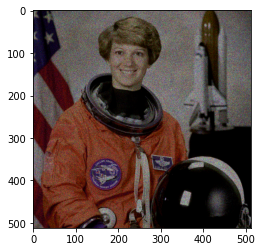

In [12]:
# Poission Noise
def add_poisson_noise( src, cnt_ratio = 0.1):
  src_lowcnt = src*cnt_ratio
  poisson_noise = np.random.poisson(src_lowcnt).astype(np.float32)
  noisy_image = poisson_noise
  noisy_image = cv2.normalize(noisy_image,  noisy_image, 0, 255, cv2.NORM_MINMAX)
  noisy_image = noisy_image.astype(np.uint8)
  return noisy_image

astro = data.astronaut()
#astro = cv2.cvtColor(astro,cv2.COLOR_RGB2GRAY).astype(np.float)
astro_float = astro.astype(np.float32)

astro_noise = add_poisson_noise(astro_float, 0.1)
plt.imshow(astro_noise)

# Filtering

입력 이미지에서 원하지 않는 값들은 걸러내고 원하는 값들을 추출하여 결과로 얻는 방법 또는 컴포넌트를 지칭.

대표적인 예로 edge 의 위치와 방향을 검출하여 Image Analysis 및 Image Segmentation의 기본이 되는 정보를 제공하거나, 영상을 blurring 또는 Sharpening하는 filter들이 있음.

## Spacial domain filter

결과 영상의 pixel값을 계산하는데, 입력 영상 해당 위치의 픽셀 하나만이 아닌 주변의 pixel들을 값을 이용하는 Filter

## Frequency domain filter

입력 영상으로부터 FT등을 통해 freq. domain으로 변환하여 처리가 이루어지는 filter.

## Convolution

실제로 image filtering은 **filter** 또는 **kernel** 또는 **window**라고 하는 행렬과 입력 영상의 Convolution으로 이루어짐.

Convolution은 기호 $\otimes$ or $*$ 등으로 표기됨.

원래 convoluton의 수식은 다음과 같음.

$$
\begin{aligned}
g(x,y) &= \int^\infty_{-\infty}\int^\infty_{-\infty}f(\xi,\eta)h(x-\xi,y-\eta)d\xi d\eta
\\
&= h(x,y)*f(x,y)\\
&= f(x,y)*h(x,y)\end{aligned}$$
where
* $h(x,y)$ : filter or kernel
* $f(x,y)$ : original image
* $g(x,y)$ : output image

하지만, 이미지 처리에서는 대부분 kernel을 대칭적인 것을 사용하다 보니 cross-correlation과 차이가 없는게 일반적임.

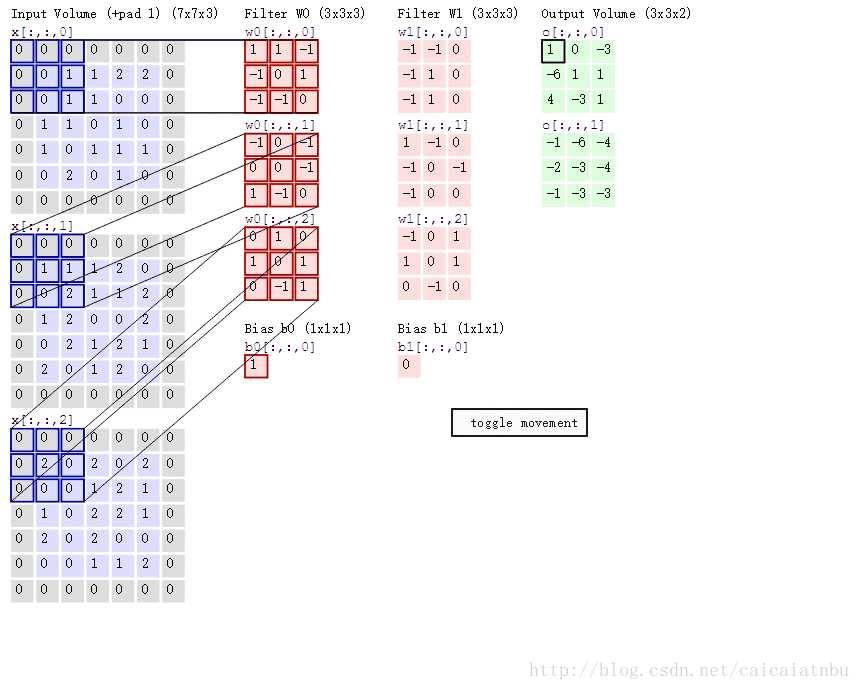

OpenCV 는 `filter2D`를 통해 convolution을 제공.

`dst = cv2.filter2D(src, ddepth, kernel [,dst [,anchor [,delta [, borderType]]]])`
* `src` : input image
* `ddepth` : output imaget dtype : -1 입력과 동일 / `CV_8U`,`CV_16U`, `CV16S`, `CV_32F`, `CV_64F`
* `kernel` : kernel or window or mask or filter matrix
* `dst` : output image
* `anchor` : kernel의 기준점. 결과값이 치환될 위치. default (-1,-1) 로 kernel의 중앙을 의미
* `delta` : 결과값에 추가할 값.
* `borderType` : padding 형태.

uint8 (512, 512, 3)


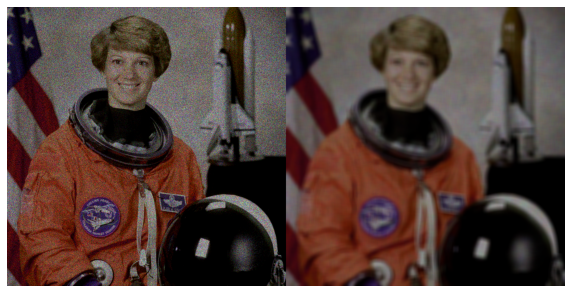

In [14]:
#img = cv2.imread('./data/lena.jpg')
img = astro_noise.copy()
print(img.dtype, img.shape)

k_size = 10
kernel = np.full((k_size,k_size),1./(k_size**2))
blured = cv2.filter2D(img, -1, kernel)

plt.figure(figsize=(10,20))
plt.imshow(np.concatenate((img,blured),axis=1))
plt.axis('off')
plt.show()


# Smoothing Filter (or LPF)

* 영상의 잡음을 제거하며 blur하게 함.
* bluring or smoothing filter라고 불림
* 공간주파수 domain에서 고주파의 성분을 제거하고 저주파의 성분들만 남기기 때문에**Low Pass Filter(LPF)**라고 불림.

## BoxFilter

* 균일한 weight로 구성된 kernel
* kernel 영역에 있는 pixel들의 합을 가지도록 함 (`normalize=False`가 기본).

$$K=n \begin{bmatrix}
1 & 1 & 1 & ... & 1  \\
1 & 1 & 1 & ... & 1 \\
 & & ... & & \\
1 & 1 & 1 & ... & 1
\end{bmatrix}$$</p>

$$ 
n = \begin{cases} \frac{1}{k_\text{w} \times k_\text{h}}  & \text{if normalize =True} \\ 
1 & \text{else} \end{cases} 
$$

`cv2.boxFilter(src, ddepth, ksize[, dst[, anchor[, normalize[, borderType]]]])`:

* `src`: input image
* `ddepth`: output image depth (-1일 경우 input image와 같음)
* `ksize`: kernel size
* `anchor`: 결과값이 저장될 위치, default: (-1,-1) =center of kernel.
* `normalize`: flag, 정규화 여부
* `borderType`: padding 방식

  


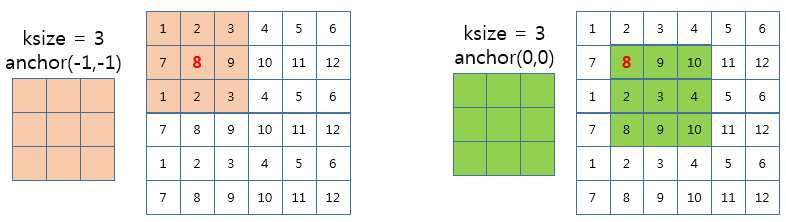

## `blur` filter

`cv2.boxFilter`에서 `normalize=True`한 Filter이다.

`cv2.blur(src, ksize[, dst[, anchor[, borderType]]])` 

## Median Filter

* kernel 범위의 pixel intensity 들의 median으로 output image 의 대상 pixel intensity를 바꿈.
* **salt and pepper noise** or **impulse noise** 제거에 탁월함.
* 가장 간단한 비선형 필터.

`cv2.medianBlur(src, ksize[, dst])` <br>

## Gaussian Filter

kernel이 다음의 2D Gaussian distribution을 따름.

$$
f(x,y) = \dfrac{1}{2\pi\sigma_\text{x}\sigma_\text{y}} \exp \left( -\left( \dfrac{(x-x_o)^2}{2\sigma_\text{x}^2}+\dfrac{(y-y_o)^2}{2\sigma_\text{y}^2}\right)\right)
$$

* 새로운 pixel의 값을 결정할 때, 원래 해당 위치의 값에 가장 큰 영향을 받고, 나머지 주변 pixel에서는 가까울수록 많은 영향을 받게 됨.
* standard deviation이 클수록 blurring이 심해짐.

`cv2.GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]])`
* `ksize` : odd number
* `sigmaX` : 0 일 경우 자동 생성됨. $\sigma_\text{x}=0.3( 0.5(\text{ksize_x}-1) -1) +0.8$
* `sigmaY` : default는 `sigmaX`임.
* `borderType` : padding 방식.

`cv2.GaussianKernel(ksize,sigma [,ktype])`
* `ret` : 1차원 가우시안 커널이므로 `ret*ret.T`를 통해 2차원으로 만들어 사용하는게 일반적.

## bilateral filter

* 픽셀 간의 거리 뿐 아니라 두 픽셀의 intensity의 차이도 고려한 가중치의 Kernel을 사용.
* 기존의 bluring filter들과 달리, edge perservaton이 우수함.

$$
f_\text{filtered}(\textbf{r})=\dfrac{1}{W_p}\sum_{\textbf{x}_i \in \Omega}f(\textbf{r})g_r(\|f(\textbf{x})-f(\textbf{x}_i)\|)g_s(||\textbf{r}-\textbf{r}_i\|)
$$

and normalization term, $W_p$, is defined as

$$
W_p=\sum_{\textbf{x}_i \in \Omega}g_r(\|f(\textbf{x})-f(\textbf{x}_i)\|)g_s(||\textbf{r}-\textbf{r}_i\|)
$$

where
* $f_\text{filtered}$ is the filtered image;
* $f$ is the original input image to be filtered;
* $\textbf{x}$ are the position vector (or coordinate) of the current pixel to be filtered;
* $\Omega$ is the window centered in $\textbf{x}_i$, so $\textbf{x}_i \in \Omega$ isis another pixel;
* $g_r$ is the range kernel for smoothing differences in intensities (this function can be a ***Gaussian function***);
* $g_s$ is the spatial (or domain) kernel for smoothing differences in coordinates (this function can be a ***Gaussian function***).


`cv2.bilateralFilter(src, d, sigmaColor, sigmaSpace[, dst[, borderType]])`: 
* `src` : 입력 이미지, numpy의 `ndarray`
* `d` : 필터의 크기(직경). 5 이상 사용시 매우 느림.
* `sigmaColor` : color-space filter의 sigma 
* `sigmaSpace` : spatial-space filter의 sigma

> * sigmaColor와 sigmaSpace의 range는 10~150 로 사용하고, 둘다 같은 값으로 지정하는 것을 권함. 
> * sigma 를 150 이상 해보자.



In [15]:
# Define Components
IntSlider_Box = IntSlider(
    value=1,
    min=1,
    max=30,
    step=1,
    description='ksize: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


IntSlider_MedianBlur = IntSlider(
    value=1,
    min=1,
    max=20,
    step=2,
    description='ksize: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


IntSlider_Blur = IntSlider(
    value=1,
    min=1,
    max=20,
    step=1,
    description='ksize: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

IntSlider_Gaussian_KSize = IntSlider(
    value=1,
    min=1,
    max=20,
    step=2,
    description='ksize: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

IntSlider_Gaussian_Sigma = IntSlider(
    value=0,
    min=0,
    max=10,
    step=1,
    description='Sigma: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


IntSlider_Bilateral = IntSlider(
    value=0,
    min=0,
    max=30,
    step=1,
    description='d: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [30]:
wImg_original   = Image(layout = Layout(border="solid"), width="70%")
wImg_Box        = Image(layout = Layout(border="solid"), width="70%")
wImg_Blur       = Image(layout = Layout(border="solid"), width="70%")
wImg_MedianBlur = Image(layout = Layout(border="solid"), width="70%")
wImg_Gaussian   = Image(layout = Layout(border="solid"), width="70%")
wImg_Bilateral  = Image(layout = Layout(border="solid"), width="70%")

In [31]:
def imencode_ndarray2buffer(nd):
  # 이미지 파일 스트림으로 다시 인코딩을 하여 bytes object로 만들어냄.
  nd = cv2.normalize(nd,nd,0,255,cv2.NORM_MINMAX)
  nd = nd.astype(np.uint8)
  #print(nd)
  #plt.imshow(nd)
  return cv2.imencode(".jpeg", nd[:,:,::-1])[1].tobytes()


# load image
#img       = cv2.imread('./data/lena.jpg',0) #gray-scale
img       = astro_noise.copy()

# 이미지 파일 스트림으로 다시 인코딩을 하여 bytes object로 만들어냄.
tmpStream = cv2.imencode(".jpeg", img)[1].tobytes()
wImg_original.value = imencode_ndarray2buffer(img)

In [32]:
def layout(header, left, right):
  layout = AppLayout(header       =header,
                     left_sidebar =left,
                     center       =None,
                     right_sidebar=right)
  return layout

card0 = layout(IntSlider_Box       ,wImg_original,wImg_Box       )
card1 = layout(IntSlider_Blur      ,wImg_original,wImg_Blur      )
card2 = layout(IntSlider_MedianBlur,wImg_original,wImg_MedianBlur)
Gaussian = Box([IntSlider_Gaussian_KSize,IntSlider_Gaussian_Sigma])
card3     = layout(Gaussian,wImg_original,wImg_Gaussian)
card4 = layout(IntSlider_Bilateral ,wImg_original,wImg_Bilateral  )

tab_card = widgets.Tab()
tab_card.children = [card0, card1, card2, card3, card4]
tab_card_titles   = ['Box Filter','Blur Filter','MedianBlur Filter','Gaussian Filter','Bilateral Filter']
for i,c_title in enumerate(tab_card_titles):
  tab_card.set_title(i, c_title)

#display.display(tab_card)

In [33]:
# Event Handler

def on_value_change_Box(event_parameter):
  ksize          = event_parameter['new']
  Box_img        = cv2.boxFilter(img, ddepth=-1, ksize=(ksize,ksize))
  wImg_Box.value = imencode_ndarray2buffer(Box_img)
    #wImg_Box.value = tmpStream

def on_value_change_Blur(event_parameter):
  ksize = event_parameter['new']
  Blurr_img = cv2.blur(img,ksize=(ksize,ksize))
  # tmpStream = cv2.imencode(".jpeg", Blurr_img)[1].tobytes()
  wImg_Blur.value = imencode_ndarray2buffer(Blurr_img)

def on_value_change_MedianBlur(event_parameter):
  ksize = event_parameter['new']
  MedianBlur_img = cv2.medianBlur(img,ksize=ksize)
  # tmpStream = cv2.imencode(".jpeg", MedianBlur_img)[1].tostring()
  wImg_MedianBlur.value = imencode_ndarray2buffer(MedianBlur_img)
        
def on_value_change_Gaussian(event_parameter):
  global gaussian_ksize, gaussian_sigma
  gaussian_ksize = event_parameter['new']
  Gaussian_img = cv2.GaussianBlur(img,ksize=(gaussian_ksize,gaussian_ksize),sigmaX=gaussian_sigma)
  # tmpStream = cv2.imencode(".jpeg", Gaussian_img)[1].tostring()
  wImg_Gaussian.value = imencode_ndarray2buffer(Gaussian_img)
    
def on_value_change_Gaussian2(event_parameter):
  global gaussian_ksize, gaussian_sigma
  gaussian_sigma = event_parameter['new']
  Gaussian_img = cv2.GaussianBlur(img,ksize=(gaussian_ksize,gaussian_ksize),sigmaX=gaussian_sigma)
  # tmpStream = cv2.imencode(".jpeg", Gaussian_img)[1].tostring()
  wImg_Gaussian.value = imencode_ndarray2buffer(Gaussian_img)

def on_value_change_Bilateral(event_parameter):
  d = event_parameter['new']
  Bilateral_img = cv2.bilateralFilter(img, d=d,sigmaColor = 100, sigmaSpace = 100)
  #print(Bilateral_img.shape)
  #plt.imshow(Bilateral_img)
  wImg_Bilateral.value = imencode_ndarray2buffer(Bilateral_img)
    
#Bind Component into EventHandler
IntSlider_Box.observe            (on_value_change_Box,       names='value')
IntSlider_MedianBlur.observe     (on_value_change_MedianBlur,names='value')
IntSlider_Blur.observe           (on_value_change_Blur,      names='value')
IntSlider_Gaussian_KSize.observe (on_value_change_Gaussian,  names='value')
IntSlider_Gaussian_Sigma.observe (on_value_change_Gaussian2, names='value')
IntSlider_Bilateral.observe      (on_value_change_Bilateral, names='value')


In [34]:
#초기화 작업

import warnings
warnings.filterwarnings(action='ignore')
# warnings.filterwarnings(action='default')


gaussian_ksize, gaussian_sigma = 1,0

Box_img = cv2.boxFilter(img,ddepth=-1,ksize=(1,1))
#tmpStream = cv2.imencode(".jpeg", Box_img)[1].tostring()
wImg_Box.value = imencode_ndarray2buffer(Box_img)

Blurr_img = cv2.blur(img,ksize=(1,1))
#tmpStream = cv2.imencode(".jpeg", Blurr_img)[1].tostring()
#wImg_Blur.value = tmpStream
wImg_Blur.value = imencode_ndarray2buffer(Blurr_img)
    
MedianBlur_img = cv2.medianBlur(img,ksize=1)
#tmpStream = cv2.imencode(".jpeg", MedianBlur_img)[1].tostring()
#wImg_MedianBlur.value = tmpStream
wImg_MedianBlur.value = imencode_ndarray2buffer(MedianBlur_img)

Gaussian_img = cv2.GaussianBlur(img,ksize=(gaussian_ksize,gaussian_ksize),sigmaX=gaussian_sigma)
#tmpStream = cv2.imencode(".jpeg", Gaussian_img)[1].tostring()
#wImg_Gaussian.value = tmpStream
wImg_Gaussian.value = imencode_ndarray2buffer(Gaussian_img)


Bilateral_img = cv2.bilateralFilter(img,d=0,sigmaColor = 10, sigmaSpace = 10)
#tmpStream = cv2.imencode(".jpeg", Bilateral_img)[1].tostring()
wImg_Bilateral.value = imencode_ndarray2buffer(Bilateral_img)

display.display(tab_card)

# Edge Detection Filter

* 영상의 대표적 feature로는 blob, corner, edge를 들 수 있는데, 이중 edge는 object과 background를 분리하는 기본이 되어 매우 중요한 feature임.
* 특히 corner와 edge는 자신을 경계로 하여 주변의 pixel intensity가 급격하게 변화하는 특징을 가지며 이때문에 differentiation을 이용한 filter를 통해 검출가능함.
* corner와 edge는 frequency domain에서 high freq.에 해당하므로 이를 검출하는 필터들은 High Pass Filter(HPF)에 속함.

## Sobel Filter  

* 디지털 형태의 1차 미분을 구현. 
* 1차미분을 통하여 특정 방향의 Edge를 검출.  

`cv2.Sobel(src, ddepth, dx, dy[, dst[, ksize[, scale[, delta[, borderType]]]]])` 

- src: input
- dx: x에 대한 미분 차수
- dy: y에 대한 미분 차수
- ksize: Sobel kernel 크기 (1,3,5,7 만 가능)

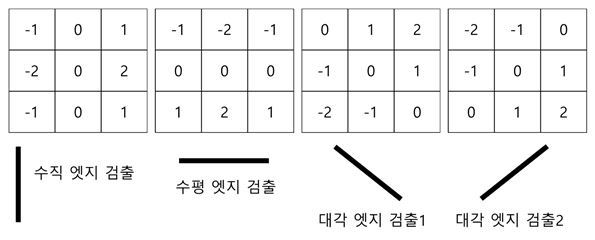

출처:<a href="https://bskyvision.com/43">bskyvision 블로그</a>

## Laplacian Filter

* the second order derivative
* 1차 미분 필터 (예: Sobel Filter)과 비교할 경우, 영상내에 blob이나, 섬세한 부분을 더 잘 검출(or 강조)함.
* 문제는 noise도 강조한다는 점임.
* **2차 미분은 주로 image enhancement에 사용하며 1차 미분은 feature extraction**에 사용되는 경우가 많음.

`cv2.Laplacian(src, ddepth[, dst[, ksize[, scale[, delta[, borderType]]]]])`

**example(3 x 3, ksize=1)**  

$$\begin{bmatrix}
0 & 1 & 0  \\
1 & -4 & 1 \\
0 & 1 & 0 
\end{bmatrix}$$

Tayler series로 부터 유도한 2차 미분 근사식 $f^{\prime \prime}(x) = f(x+1) - 2f(x) + f(x-1)$ 을 2개의 독립변수로 확장시 다음과 같음.  
$$f^{\prime \prime}(x,y) = f(x-1,y) + f(x,y-1) + f(x+1,y) + f(x,y+1) - 4f(x,y)$$
이 식의 계수들이 바로 kernel의 coefficient임.

> noise에 민감해서 Laplacian을 단독으로 사용하기 보다 Gausian Filter로 blurring시켜서 noise를 제거 후 Laplacian Filter를 적용하는 Laplacian of Gaussian (LoG)를 일반적으로 사용

## Sobel Filter1

mag: 0.0 1080.467529296875 (0, 0) (100, 400)


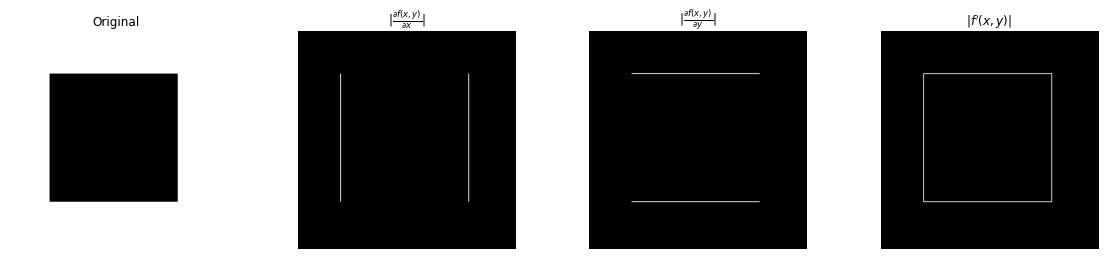

In [35]:


src = cv2.imread('./data/rectangle.jpg',cv2.IMREAD_GRAYSCALE) 

gx = cv2.Sobel(src,cv2.CV_32F,1,0,ksize=3)
gy = cv2.Sobel(src,cv2.CV_32F,0,1,ksize=3)

mag_X = np.abs(gx)
mag_X = cv2.normalize(mag_X,None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)

mag_Y = np.abs(gy)
mag_Y = cv2.normalize(mag_Y,None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)

mag = cv2.magnitude(gx,gy) # l2-norm
minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(mag)
print('mag:',minVal,maxVal,minLoc,maxLoc)
mag_M = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)

plt.figure(figsize=(20,4))
imgae1=plt.subplot(1,4,1)
imgae1.set_title('Original')
plt.axis('off')
plt.imshow(src, cmap="gray")

imgae2=plt.subplot(1,4,2)
plt.title(r'$\|\frac{\partial f(x,y)}{\partial x}\|$')
plt.axis('off')
plt.imshow(mag_X, cmap="gray")

imgae3=plt.subplot(1,4,3)
imgae3.set_title(r'$\|\frac{\partial f(x,y)}{\partial y}\|$')
plt.axis('off')
plt.imshow(mag_Y, cmap="gray")

imgae3=plt.subplot(1,4,4)
imgae3.set_title(r'$\|f^{\prime}(x,y)\|$')
plt.axis('off')
plt.imshow(mag_M, cmap="gray")

plt.show()

## Sobel Filter2(gradient orientation)
<code>cv2.cartToPolar(x, y[, magnitude[, angle[, angleInDegrees]]])</code>는 2D vector의 magnitude계산및 각도도 Return하는 함수이다.  
결과 angleM에서 색깔은 각각의 의미와 같다.  
- 빨강: magnitude의 값 중 angle = 0 인곳
- 초록: magnitude의 값 중 angle = 90 인곳
- 파랑: magnitude의 값 중 angle = 180 인곳
- 노랑: magnitude의 값 중 angle = 270 인곳

angle:  0.0 359.94378662109375 (0, 0) (400, 399)


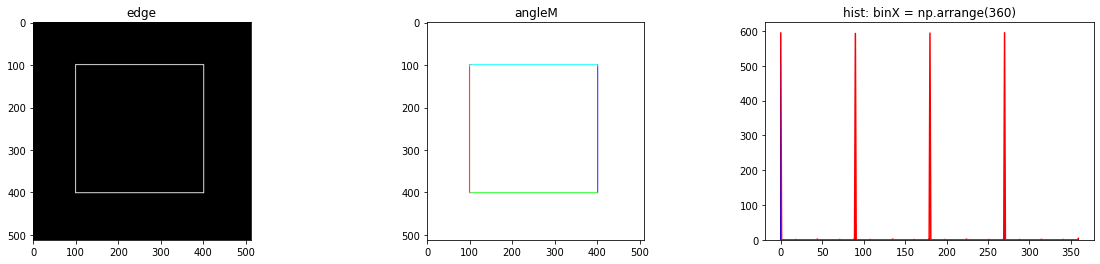

In [36]:
src = cv2.imread('./data/rectangle.jpg',cv2.IMREAD_GRAYSCALE)

gx = cv2.Sobel(src,cv2.CV_32F,1,0,ksize=3)
gy = cv2.Sobel(src,cv2.CV_32F,0,1,ksize=3)

mag,angle = cv2.cartToPolar(gx,gy,angleInDegrees =True)
minVal,maxVal,minLoc,maxLoc = cv2.minMaxLoc(angle)
print('angle: ',minVal,maxVal,minLoc,maxLoc)

ret,edge = cv2.threshold(mag,100,255,cv2.THRESH_BINARY)
edge = edge.astype(np.uint8)

width,height = mag.shape[:2]
angleM = np.full((width,height,3),(255,255,255),dtype=np.uint8)
for y in range(height):
    for x in range(width):
        if edge[y,x]!=0:
            if angle[y,x] == 0:
                angleM[y,x] = (0,0,255) # red
            elif angle[y,x] == 90:
                angleM[y,x] = (0,255,0) # green
            elif angle[y,x] == 180:
                angleM[y,x] = (255,0,0) # blue
            elif angle[y,x] == 270:
                angleM[y,x] = (0,255,255) # yellow
            else:
                angleM[y,x] = (128,128,128) # gray

hist = cv2.calcHist(images=[angle],channels=[0],mask=edge,histSize=[360],ranges=[0,360])
hist = hist.flatten()
                
plt.figure(figsize=(20,4))
imgae1=plt.subplot(1,3,1)
imgae1.set_title('edge')
plt.imshow(edge, cmap="gray")

imgae2=plt.subplot(1,3,2)
imgae2.set_title('angleM')
plt.imshow(angleM)

imgae3=plt.subplot(1,3,3)
imgae3.set_title('hist: binX = np.arrange(360)')
plt.plot(hist,color='r')
binX=np.arange(360)
plt.bar(binX,hist,width=1,color='b')

plt.show()